In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm
from pathlib import Path
from multiprocessing import Pool
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import timm
import fastai.text.all as fastai
from fastai.callback.schedule import Learner
import transformers

# from torch.utils.tensorboard import SummaryWriter
from tensorboardX import SummaryWriter
# %load_ext tensorboard

import spacy
import re
import nltk
import torchtext
from torchtext.data.metrics import bleu_score

# pip install ipyexperiments
# from ipyexperiments import IPyExperimentsCPU, IPyExperimentsPytorch

import warnings
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)
torch.manual_seed(seed + 1)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed + 2)

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'
    return device

device = get_device()

print(f'device: {device}')

device: cuda


In [3]:
model_path = Path.cwd() / 'models'

In [4]:
def get_optimizer(model, optimizer='sgd', lr=0.001, weight_decay=0, momentum=0, betas=(0.9, 0.999), eps=1e-8):
    if optimizer == 'sgd':
        opt = torch.optim.SGD(
            model.parameters(),
            lr=lr, 
            weight_decay=weight_decay, 
            momentum=momentum
        )
    if optimizer == 'adam':
        opt = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    if optimizer == 'radam':
        opt = torch.optim.RAdam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    return opt

def train_classifier(train_data, model, opt, loss_fn, test_data=None, num_epochs=10, plot_loss=True, batch_size=32,
                     tensorboard=False, print_stats=True, show_batches_bar=False, shuffle=True, scheduler=None,
                     print_every=1, n_grad_accums=1, use_multi_gpus=False, collate_fn=None, pin_memory=False,
                     device=device):
    from torch.utils.data import DataLoader
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    num_workers = 1 if device == 'cuda' else 0
    pin_memory = True if (pin_memory and device == 'cuda') else False
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn, 
                              num_workers=num_workers, pin_memory=pin_memory)
    if test_data is not None:
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, 
                                 num_workers=num_workers, pin_memory=pin_memory)
    if use_multi_gpus:
        orig_model = model
        model = nn.DataParallel(model)
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        total_losses = []
        total_correct = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        for i, (X, y) in enumerate(iterator):
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y).mean() # mean is for multi-gpu losses, avg them together
            loss /= n_grad_accums # rescale loss for grad accumulation
            loss.backward()
            if i % n_grad_accums == 0: # only step when every n_grad_accums grad updates
                opt.step()
                opt.zero_grad()
            total_losses.append(float(loss))
            total_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
        train_loss = np.mean(total_losses)
        train_acc = sum(total_correct) / len(train_data)
        losses.append(train_loss)
        
        if test_data is not None:
            model = model.eval()
            opt.zero_grad()
            total_losses = []
            total_correct = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, y in iterator:
                X = X.to(device)
                y = y.to(device)
                yhat = model(X)
                loss = loss_fn(yhat, y).mean()
                total_losses.append(float(loss))
                total_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
            test_loss = np.mean(total_losses)
            test_acc = sum(total_correct) / len(test_data)
        else:
            test_loss = -999
            test_acc = -999
            
        if scheduler is not None:
            scheduler.step()

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Training Accuracy", train_acc, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)
        if print_stats and epoch % print_every == 0:
            s1 = f'epoch: {epoch: <3}   ' 
            s2 = f'train loss: {round(train_loss, 5): <6}   train acc: {round(train_acc, 5): <6}   ' 
            s3 = f'test loss: {round(test_loss, 5): <6}   test acc: {round(test_acc, 5): <6}'
            print(s1 + s2 + s3)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
        plt.title('Training Loss')
        plt.xlabel('epochs')
        plt.show()
    if tensorboard:
        writer.flush()
        writer.close()
    model = model if not use_multi_gpus else orig_model
    return model

def train_seq2seq(train_data, model, opt, loss_fn, model_type, test_data=None, num_epochs=10, plot_loss=True, 
                  batch_size=32, tensorboard=False, print_stats=True, show_batches_bar=False, shuffle=True, 
                  scheduler=None, print_every=1, n_grad_accums=1, use_multi_gpus=False, grad_clip=1, 
                  teacher_forcing=0.5, collate_fn=None, pin_memory=False, device=device):
    from torch.utils.data import DataLoader
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    num_workers = 1 if device == 'cuda' else 0
    pin_memory = True if (pin_memory and device == 'cuda') else False
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn, 
                              num_workers=num_workers, pin_memory=pin_memory)
    if test_data is not None:
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, 
                                 num_workers=num_workers, pin_memory=pin_memory)
    if use_multi_gpus:
        orig_model = model
        model = nn.DataParallel(model)
       
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        total_losses = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        # if not specified, use heavy teacher forcing early in training and decay it linearly to zero
        teacher_forcing = (1 - epoch / num_epochs) * teacher_forcing
        for i, (X, Y) in enumerate(iterator):
            X = X.to(device).long()
            Y = Y.to(device).long()
            bs, bptt = Y.shape[0], Y.shape[1]
            if model_type == 'seq2seq_rnn':
                Yhat = model(X, h=None, Y=Y, teacher_forcing=teacher_forcing)
            if model_type == 'seq2seq_transformer':
                Yhat = model(X, Y=Y)
            if model_type == 'lm_rnn':
                Yhat = model(X, h=None)
            if model_type == 'lm_transformer':
                Yhat = model(X)
            y = Y.reshape(bs * bptt,)
            yhat = Yhat.reshape(bs * bptt, -1)
            loss = loss_fn(yhat, y).mean() # mean is for multi-gpu losses, avg them together
            loss /= n_grad_accums # rescale loss for grad accumulation
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            if i % n_grad_accums == 0: # only step when every n_grad_accums grad updates
                opt.step()
                if scheduler is not None:
                    scheduler.step()
                opt.zero_grad()
            total_losses.append(float(loss))
            if tensorboard:
                iters = epoch * len(train_loader) + i
                writer.add_scalar("Training Loss", float(loss), iters)
        train_loss = np.mean(total_losses)
        losses.append(train_loss)
        
        if test_data is not None:
            model = model.eval()
            opt.zero_grad()
            total_losses = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, Y in iterator:
                X = X.to(device)
                Y = Y.to(device)
                bs, bptt = Y.shape[0], Y.shape[1]
                if model_type == 'rnn':
                    Yhat = model(X, h=None, Y=Y)
                if model_type == 'seq2seq_transformer':
                    Yhat = model(X, Y=Y)
                if model_type == 'lm_rnn':
                    Yhat = model(X, h=None)
                if model_type == 'lm_transformer':
                    Yhat = model(X)
                y = Y.reshape(bs * bptt,)
                yhat = Yhat.reshape(bs * bptt, -1)
                loss = loss_fn(yhat, y).mean()
                total_losses.append(float(loss))
            test_loss = np.mean(total_losses)
        else:
            test_loss = -999
            
        if tensorboard:
            writer.add_scalar("Test Loss", test_loss, epoch)
        if print_stats and (epoch % print_every == 0) or (epoch == num_epochs - 1):
            s1 = f'epoch: {epoch: <3}   ' 
            s2 = f'train loss: {round(train_loss, 5): <6}   test loss: {round(test_loss, 5): <6}' 
            print(s1 + s2)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
        plt.title('Training Loss')
        plt.xlabel('epochs')
        plt.show()
    if tensorboard:
        writer.flush()
        writer.close()
    model = model if not use_multi_gpus else orig_model
    return model

def predict(test_data, model, batch_size=32, collate_fn=None, device=device):
    from torch.utils.data import DataLoader
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=False)
    model = model.eval()
    preds = []
    for X, y in tqdm(test_loader):
        X = X.to(device)
        y = y.to(device)
        yhat = model(X).detach()
        preds.append(yhat.argmax(dim=-1).cpu())
    preds = torch.cat(preds, dim=0).flatten()
    return preds

def predict_seq2seq(data, model, model_type, batch_size=32, collate_fn=None, device=device):
    # returns sequence flattened predictions *and* sequence flattened targets (y, yhat)
    # y.shape = yhat.shape = (bs * bptt,)
    from torch.utils.data import DataLoader
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=False) 
    model = model.eval()
    yhat = []
    y = []
    for X, Y in tqdm(data_loader):
        X = X.to(device)
        Y = Y.to(device)
        bs, bptt = Y.shape
        if model_type == 'seq2seq_rnn':
            Yhat = model(X, h=None, Y=Y).detach()
        if model_type == 'seq2seq_transformer':
            Yhat = model(X, Y=Y).detach()
        if model_type == 'lm_rnn':
            Yhat = model(X, h=None).detach()
        if model_type == 'lm_transformer':
            Yhat = model(X).detach()
        yhat.append(Yhat.reshape(bs * bptt, -1).argmax(dim=-1).cpu())
        y.append(Y.reshape(bs * bptt, -1).cpu())
    yhat = torch.cat(yhat, dim=0).flatten()
    y = torch.cat(y, dim=0).flatten()
    return yhat, y

def func_over_batches(func, data, model, model_type=None, batch_size=32, collate_fn=None, device=device,
                      flatten_seqs=False):
    from torch.utils.data import DataLoader
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, pin_memory=False) 
    model = model.eval()
    scores = []
    for X, Y in tqdm(data_loader):
        X = X.to(device)
        Y = Y.to(device)
        if model_type is None:
            Yhat = model(X).detach()
        if model_type == 'seq2seq_rnn':
            Yhat = model(X, h=None, Y=Y).detach()
        if model_type == 'seq2seq_transformer':
            Yhat = model(X, Y=Y).detach()
        if model_type == 'lm_rnn':
            Yhat = model(X, h=None).detach()
        if flatten_seqs:
            bs, bptt = Y.shape
            Yhat = Yhat.reshape(bs * bptt, -1).squeeze()
            Y = Y.reshape(bs * bptt, -1).squeeze()
        score = func(Yhat, Y)
        scores.append(float(score))
    return sum(scores) / len(scores)

class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
def garbage_collect():
    import gc
    return gc.collect()

def text_from_iter(data_iter):
    corpus = []
    for text in data_iter:
        corpus.append(text)
    return corpus

def accuracy(yhat, y):
    return (y == yhat).sum().item() / len(y)

def clean_text(tokens):
    text = []
    prev_token = '<bos>'
    for token in tokens:
        if token != '<unk>':
            if prev_token == '<up>':
                token = token.upper()
            if prev_token == '<cap>':
                token = token.title()
        if token == '@-@':
            token = '-'
        if token not in ['<bos>', '<eos>', '<up>', '<cap>']:
            text.append(token)
        prev_token = token
    return ' '.join(text)

def generate_text(seed, model, vocab, tokenizer, max_len=20, temperature=0.5, device=device, skip_tokens=['<unk>']):
    stoi, itos = vocab.get_stoi(), vocab.get_itos()
    model = model.eval()
    seed_tokens = ['<bos>'] + tokenizer(seed)
    x = torch.tensor([stoi[word] for word in seed_tokens]).long().to(device)[None, :]
    idxs = []
    probs = []
    idx_prev = stoi['<unk>']
    for _ in range(max_len):
        yhat = model(x)
        prob = yhat[:, -1].softmax(dim=-1)
        if (torch.rand(1) < temperature) or (idx_prev in [stoi[token] for token in skip_tokens]):
            idx = torch.multinomial(prob, 1, replacement=True).item()
        else:
            idx = prob.argmax(-1).item()
        idxs.append(idx)
        probs.append(prob.unsqueeze(dim=1))
        x = torch.cat([x, torch.ones(1, 1).fill_(idx).long().to(device)], dim=1)
        idx_prev = idx
        if itos[idx] == '<eos>':
            break
    probs = torch.cat(probs, dim=1)
    generated = [itos[idx] for idx in idxs]
    text = seed + ' ' + clean_text(generated)
    return text

def swa(train_data, model, optimizer, num_iters=1000, swa_lr=0.0001, batch_size=32, collate_fn=None):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn)
    swa_model = torch.optim.swa_utils.AveragedModel(model).to(device)
    swa_scheduler = torch.optim.swa_utils.SWALR(optimizer, swa_lr=swa_lr)
    for i in tqdm(range(num_iters)):
        swa_model.update_parameters(model)
        swa_scheduler.step()
    torch.optim.swa_utils.update_bn(train_loader, swa_model)
    return swa_model

def gpu_mem_restore(func):
    "reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    "execute by decorating functions with: @gpu_mem_restore; def func(...):"
    import functools, traceback
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

class gpu_mem_restore_ctx():
    "context manager to reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    "execute by calling with gpu_mem_restore_ctx(): <stuff>"
    import functools, traceback
    def __enter__(self): return self
    def __exit__(self, exc_type, exc_val, exc_tb):
        if not exc_val: return True
        traceback.clear_frames(exc_tb)
        raise exc_type(exc_val).with_traceback(exc_tb) from None

In [5]:
class ModifiedTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation=F.relu, layer_norm_eps=1e-5, 
                 batch_first=True, norm_first=False, device=device, dtype=None, alpha=1, beta=1):
        kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first, **kwargs)
        self.linear1 = nn.Linear(d_model, dim_feedforward, **kwargs)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model, **kwargs)
        self.norm_first = norm_first if not (alpha == 1 and beta == 1) else False # deepnorm reqs post-norm
        self.norm1 = nn.LayerNorm(d_model, eps=layer_norm_eps, **kwargs)
        self.norm2 = nn.LayerNorm(d_model, eps=layer_norm_eps, **kwargs)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = activation
        
        self.alpha = alpha # NEW
        self.beta = beta # NEW

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super().__setstate__(state)

    def forward(self, x, src_mask=None, src_key_padding_mask=None):
        if self.norm_first:
            x = self.alpha * x + self._sa_block(self.norm1(x), src_mask, src_key_padding_mask) # UPDATED
            x = self.alpha * x + self._ff_block(self.norm2(x)) # UPDATED
        else:
            x = self.norm1(self.alpha * x + self._sa_block(x, src_mask, src_key_padding_mask)) # UPDATED
            x = self.norm2(self.alpha * x + self._ff_block(x)) # UPDATED
        return x

    def _sa_block(self, x, attn_mask, key_padding_mask):
        q, k, v = x / self.beta, x / self.beta, x # NEW
        x = self.self_attn(q, k, v, attn_mask=attn_mask, key_padding_mask=key_padding_mask, need_weights=False)[0]
        return self.dropout1(x)

    def _ff_block(self, x):
        x = self.linear2(self.dropout(self.activation(self.linear1(x))))
        return self.dropout2(x)
    
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, max_len=5000, N=10_000, dropout=0.1):
        super().__init__()
        position = torch.arange(max_len)[:, None]
        div_term = torch.exp(torch.arange(0, emb_size, 2) * (-torch.log(torch.tensor(N) / emb_size)))
        self.encoding = torch.zeros(max_len, 1, emb_size)
        self.encoding[:, 0, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 0, 1::2] = torch.cos(position * div_term)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # x.shape = y.shape = (batch_size, seq_len, emb_size)
        batch_size = x.shape[0]
        p = self.encoding[:batch_size].to(device)
        x += p
        y = self.dropout(x)
        return y
    
class Seq2SeqTransformer(nn.Module):
    def __init__(self, input_size, output_size, emb_size, num_layers=256, nhead=8, dropout=0.1, dim_feedforward=256,
                 masking=False, max_len=1024, tie_weights=False, padding_idx=None):
        super().__init__()
        self.masking = masking
        self.padding_idx = padding_idx
        self.mask = torch.triu(torch.ones(max_len, max_len)*(-torch.inf), diagonal=1).to(device)
        self.positional = PositionalEncoding(emb_size, dropout=dropout)
        self.in_embedding = nn.Embedding(input_size, emb_size, padding_idx=padding_idx)
        self.out_embedding = nn.Embedding(output_size, emb_size, padding_idx=padding_idx)
        if tie_weights:
            self.out_embedding.weight = self.in_embedding.weight
        self.transformer = nn.Transformer(emb_size, nhead, num_layers, num_layers, dropout=dropout, batch_first=True, 
                                          dim_feedforward=dim_feedforward)
        self.fc = nn.Linear(emb_size, output_size)
        
    def forward(self, X, Y=None):
        # X.shape = Y.shape = (batch_size, seq_len)
        # Yhat.shape = (batch_size, seq_len, output_size)
        batch_size, seq_len = X.shape
        mask = self.mask[:seq_len, :seq_len] if self.masking else None
        pad_mask_X = (X == self.padding_idx) if self.padding_idx is not None else None
        pad_mask_Y = (Y == self.padding_idx) if self.padding_idx is not None else None
        X = self.in_embedding(X)
        X = self.positional(X)
        Y = self.out_embedding(Y)
        Y = self.positional(Y)
        Yhat = self.transformer(X, Y, mask, mask, None, pad_mask_X, pad_mask_Y)
        del mask
        Yhat = self.fc(Yhat)
        return Yhat
    
    def encoder(self, X):
        batch_size, seq_len = X.shape
        mask = self.mask[:seq_len, :seq_len] if self.masking else None
        pad_mask = (X == self.padding_idx) if self.padding_idx is not None else None
        X = self.in_embedding(X)
        X = self.positional(X)
        Xhat = self.transformer.encoder(X, mask, pad_mask)
        del mask
        return Xhat
    
    def decoder(self, Y, Xhat):
        batch_size, seq_len = Y.shape
        mask = self.mask[:seq_len, :seq_len] if self.masking else None
        pad_mask = (Y == self.padding_idx) if self.padding_idx is not None else None
        Y = self.in_embedding(Y)
        Y = self.positional(Y)
        Yhat = self.transformer.decoder(Y, Xhat, mask, pad_mask)
        del mask
        return Yhat
    
class EncoderLM(nn.Module):
    def __init__(self, vocab_size, emb_size, num_layers=3, nhead=8, dropout=0.1, dim_feedforward=256,
                 masking=False, max_len=1024, padding_idx=None, deepnorm=False, activation=nn.GELU(),
                 norm_first=False):
        super().__init__()
        self.masking = masking
        self.padding_idx = padding_idx
        self.emb_size = emb_size
        self.alpha = (2 * num_layers)**(1/4) if deepnorm else 1
        self.beta = (8 * num_layers)**(-1/4) if deepnorm else 1
        self.mask = torch.triu(torch.ones(max_len, max_len)*(-torch.inf), diagonal=1).to(device)
        self.positional = PositionalEncoding(emb_size, dropout=dropout)
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.transformer = nn.TransformerEncoder(ModifiedTransformerEncoderLayer(
            emb_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, 
            alpha=self.alpha, beta=self.beta, activation=activation, norm_first=norm_first), num_layers)
        self.fc = nn.Linear(emb_size, vocab_size)
        self.apply(self.init_weights)

    def forward(self, X):
        # X.shape = (batch_size, seq_len)
        # Yhat.shape = (batch_size, seq_len, vocab_size)
        batch_size, seq_len = X.shape
        mask = self.mask[:seq_len, :seq_len] if self.masking else None
        pad_mask = (X == self.padding_idx) if self.padding_idx is not None else None
        X = self.embedding(X) * torch.sqrt(torch.tensor(self.emb_size))
        X = self.positional(X)
        X = self.transformer(X, mask, pad_mask)
        X = self.fc(X)
        return X
    
    def init_weights(self, layer):
        if isinstance(layer, nn.modules.linear.Linear) or \
           isinstance(layer, nn.modules.sparse.Embedding) or \
           isinstance(layer, nn.modules.linear.NonDynamicallyQuantizableLinear):
            torch.nn.init.xavier_normal_(layer.weight, gain=self.beta)
            
class Seq2SeqCrossEntropyLoss(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss(**kwargs)

    def forward(self, Yhat, Y):
        bs, bptt = Y.shape[0], Y.shape[1]
        y = Y.reshape(bs * bptt,)
        yhat = Yhat.reshape(bs * bptt, -1)
        loss = self.loss_fn(yhat, y).mean()
        return loss

## Language Model Training on Wikitext103

In [6]:
train_iter = torchtext.datasets.WikiText103(split='train')
val_iter = torchtext.datasets.WikiText103(split='valid')
test_iter = torchtext.datasets.WikiText103(split='test')

train_text = text_from_iter(train_iter) + text_from_iter(val_iter)
test_text = text_from_iter(test_iter)
len(train_text), len(test_text)

(1805110, 4358)

In [7]:
def sub_special_tokens(text):
    # put <up> token before words in all caps (easy way to recognize info from capitalizing a word)
    text = re.sub(r'(\b[A-Z][A-Z0-9]*\b)', r' <up> \1 ', text)
    # put <cap> token before words with capitalized first letter (easy way to recognize first word in a sentence)
    text = re.sub(r'(\b[A-Z][a-z0-9]+\b)', r' <cap> \1 ', text)
    return text

min_tokens = 5
max_tokens = 512

tokenizer = torchtext.data.utils.get_tokenizer('basic_english')
# sp_path = r"https://download.pytorch.org/models/text/xlmr.sentencepiece.bpe.model"
# sp_model = torchtext.data.functional.load_sp_model(sp_path)
# tokenizer = torchtext.data.functional.sentencepiece_tokenizer(sp_model)
train_data = [tokenizer(sub_special_tokens(doc)) for doc in tqdm(train_text)]
test_data = [tokenizer(sub_special_tokens(doc)) for doc in tqdm(test_text)]

train_data = [['<bos>'] + doc[:max_tokens] + ['<eos>'] for doc in train_data if len(doc) > min_tokens]
test_data = [['<bos>'] + doc[:max_tokens] + ['<eos>'] for doc in test_data if len(doc) > min_tokens]

  0%|          | 0/1805110 [00:00<?, ?it/s]

  0%|          | 0/4358 [00:00<?, ?it/s]

In [8]:
vocab_size = 30_000
specials = ['<unk>', '<pad>', '<bos>', '<eos>', '<up>', '<cap>']
vocab = torchtext.vocab.build_vocab_from_iterator(train_data, max_tokens=vocab_size+1, specials=specials, 
                                                  special_first=True)
vocab.set_default_index(vocab['<unk>']) # must do this to deal with unknown tokens or will get key errors!
stoi = vocab.get_stoi()
itos = vocab.get_itos()
vocab_size

30000

In [9]:
len(train_data), len(test_data)

(1140799, 2758)

In [10]:
def collate_fn(batch, vocab=vocab):
    from torch.nn.utils.rnn import pad_sequence
    stoi = vocab.get_stoi()
    pad_token = stoi['<pad>']
    X = [torch.tensor(vocab(doc)).long() for doc in batch]
    X = pad_sequence(X, batch_first=True, padding_value=pad_token)
    Y = torch.roll(X, shifts=-1, dims=1)
    Y[:, -1] = pad_token
    return X, Y

batch = train_data[:10]
X, Y = collate_fn(batch, vocab=vocab)
X.shape, Y.shape

(torch.Size([10, 318]), torch.Size([10, 318]))

In [11]:
vocab_size = len(vocab)
emb_size = 768
dim_feedforward = 2048
num_layers = 8
nhead = 12
padding_idx = stoi['<pad>']

In [13]:
model = EncoderLM(vocab_size, emb_size, num_layers=num_layers, nhead=nhead, dim_feedforward=dim_feedforward,
                  masking=True, padding_idx=padding_idx, dropout=0.1, max_len=525, deepnorm=True).to(device)
print(sum([p.numel() for p in model.parameters()]))
del model
garbage_collect()
torch.cuda.empty_cache()

90215724


SuggestedLRs(valley=9.120108734350652e-05)

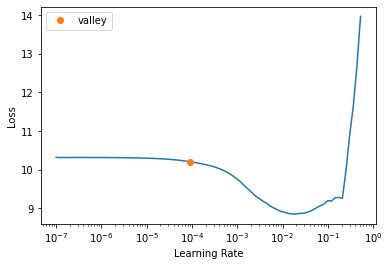

In [14]:
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=collate_fn, num_workers=1,
                          pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn, num_workers=1,
                         pin_memory=True, shuffle=False)
dls = fastai.DataLoaders(train_loader, test_loader)

model = EncoderLM(vocab_size, emb_size, num_layers=num_layers, nhead=nhead, dim_feedforward=dim_feedforward,
                  masking=True, padding_idx=padding_idx, dropout=0.07, max_len=525, deepnorm=True).to(device)
loss_fn = Seq2SeqCrossEntropyLoss(ignore_index=padding_idx)

learn = Learner(dls, model, loss_func=loss_fn, metrics=fastai.accuracy, opt_func=fastai.Adam,
                cbs=[fastai.GradientClip]) #, fastai.MixedPrecision])
learn.lr_find()

In [82]:
learn.fit_one_cycle(1, 1e-4) # train loss: 3.396, test loss: 3.647
torch.save(learn.model.state_dict(), model_path / 'lm_8_layers.pth')
torch.save(vocab, model_path / 'vocab_8_layers.pth')

In [12]:
train_sample = np.random.choice(train_data, size=200_000)

In [13]:
batch_size = 16
train_loader = DataLoader(train_sample, batch_size=batch_size, collate_fn=collate_fn, num_workers=1,
                          pin_memory=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=collate_fn, num_workers=1,
                         pin_memory=True, shuffle=False)
dls = fastai.DataLoaders(train_loader, test_loader)

model = EncoderLM(vocab_size, emb_size, num_layers=num_layers, nhead=8, dim_feedforward=dim_feedforward,
                  masking=True, padding_idx=padding_idx, dropout=0.1, max_len=525, deepnorm=True).to(device)
model.load_state_dict(torch.load(model_path / 'lm_8_layers.pth', map_location=torch.device(device)))
vocab = torch.load(model_path / 'vocab_8_layers.pth')

loss_fn = Seq2SeqCrossEntropyLoss(ignore_index=padding_idx)

learn = Learner(dls, model, loss_func=loss_fn, metrics=fastai.accuracy, opt_func=fastai.Adam,
                cbs=[fastai.GradientClip])

# learn.lr_find(start_lr=1e-8, end_lr=1e-3)

In [14]:
learn.fit_one_cycle(1, 5e-5, wd=1e-10)
torch.save(learn.model.state_dict(), model_path / 'lm_8_layers.pth')
torch.save(vocab, model_path / 'vocab_8_layers.pth')

epoch,train_loss,valid_loss,accuracy,time
0,3.495250,3.399788,0.155488,1:16:16


In [14]:
learn.fit_one_cycle(1, 2e-6, wd=1e-10)

epoch,train_loss,valid_loss,accuracy,time
0,3.466055,3.392943,0.155903,2:31:09


In [16]:
torch.save(learn.model.state_dict(), model_path / 'lm_8_layers.pth')
torch.save(vocab, model_path / 'vocab_8_layers.pth')

In [17]:
y, yhat = predict_seq2seq(test_data, learn.model, model_type='lm_transformer', batch_size=8, collate_fn=collate_fn)
y.shape, yhat.shape

  0%|          | 0/345 [00:00<?, ?it/s]

(torch.Size([614864]), torch.Size([614864]))

In [18]:
acc = accuracy(y, yhat)
acc

0.17513629030159514

In [19]:
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_idx)
loss = func_over_batches(loss_fn, test_data, learn.model, batch_size=16, collate_fn=collate_fn, flatten_seqs=True)
loss

  0%|          | 0/173 [00:00<?, ?it/s]

3.3924907935148028

In [20]:
skip_tokens = ['<unk>', '.']

In [21]:
seed = 'This is a story about'
print(generate_text(seed, model, vocab, tokenizer, max_len=100, temperature=0.7, skip_tokens=skip_tokens))

This is a story about his father ' s life . He travels to Jacksonville , Florida , where he visits Sixteenth Thomas Street , where he encounters <unk> ( <unk> Street ) , a military component . He is promptly arrested by <unk> , and unsuccessful , although he is adept at firing his shotgun . He claims he extensively on the security arrangements by accurate space and <unk> , and is unsuccessful . He is also mr . <unk> Street and takes his name from the <unk>


In [22]:
opt = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0)
swa_model = swa(train_data, model, opt, swa_lr=3e-6, num_iters=10_000, batch_size=16)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
y, yhat = predict_seq2seq(test_data, swa_model, model_type='lm_transformer', batch_size=12, collate_fn=collate_fn)
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_idx)
loss = func_over_batches(loss_fn, test_data, swa_model, batch_size=12, collate_fn=collate_fn, flatten_seqs=True)
acc = accuracy(y, yhat)
loss, acc

  0%|          | 0/230 [00:00<?, ?it/s]

  0%|          | 0/230 [00:00<?, ?it/s]

(3.395088297387828, 0.16128495937881948)

In [24]:
seed = 'This is a story about'
print(generate_text(seed, swa_model, vocab, tokenizer, max_len=100, temperature=0.7))

This is a story about civil war that follows the Great War of the United States . According to <unk> , the Great War Memorial is sometimes referred to as the Fourth Civil War memorial at a <unk> with Britain ' s War Memorial Memorial Chapel .


In [23]:
del train_loader
del test_loader
del dls
del loss_fn
del model
learn.destroy()
del learn
torch.cuda.empty_cache()
garbage_collect()

0